In [1]:
%matplotlib inline

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow.compat.v1.keras as kr
import tensorflow.compat.v1.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# encoder
img_shape = (28, 28, 1)
latent_dim = 2

input_layer = kr.layers.Input(shape=img_shape)

e = kr.layers.Conv2D(32, 3, padding='same', activation='relu')(input_layer)
e = kr.layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(e)
e = kr.layers.Conv2D(64, 3, padding='same', activation='relu')(e)
e = kr.layers.Conv2D(64, 3, padding='same', activation='relu')(e)

shape_before_flattening = K.int_shape(e)
flat = kr.layers.Flatten()(e)
x = kr.layers.Dense(32, activation='relu')(flat)

# 가정한 확률분포의 모수
z_mean = kr.layers.Dense(latent_dim)(x)
z_log_var = kr.layers.Dense(latent_dim)(x)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
def sampling(args):

    # Reparameterization trick for back-propagation
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1)
    return z_mean + K.exp(z_log_var) * epsilon


z = kr.layers.Lambda(sampling)([z_mean, z_log_var])

In [4]:
# Decoder
decoder_input = kr.layers.Input(K.int_shape(z)[1:])

x = kr.layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)
x = kr.layers.Reshape(shape_before_flattening[1:])(x)
x = kr.layers.Conv2DTranspose(32, 3, padding='same', activation='relu',
                           strides=(2, 2))(x)
x = kr.layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = kr.Model(decoder_input, x)
z_decoded = decoder(z)

In [5]:
class CustomVariationalLayer(kr.layers.Layer):

    def vae_loss(self, x, z_decoded):

        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # 여기에서 - 가 곱해져 있다.
        cross_entropy_loss = kr.metrics.binary_crossentropy(x, z_decoded)

#         kl_loss = 0.5 * K.mean(K.square(z_mean) + K.exp(z_log_var) - z_log_var - 1, axis=-1)
        kl_loss = -5e-4 * K.mean(1 + z_log_var -
                                 K.square(z_mean) - K.exp(z_log_var), axis=-1)

        return K.mean(cross_entropy_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x


y = CustomVariationalLayer()([input_layer, z_decoded])

In [6]:
vae = kr.Model(input_layer, y)
vae.compile(optimizer='adam', loss=None)
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [24]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape, x_test.shape)

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

(60000, 28, 28) (10000, 28, 28)


In [8]:
%%time
vae.fit(x=x_train, y=None, shuffle=True, epochs=30,
        batch_size=100, validation_data=(x_test, None), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 7s 117us/sample - loss: 0.2519 - val_loss: 0.2135
Epoch 2/30
60000/60000 [==============================] - 5s 79us/sample - loss: 0.2087 - val_loss: 0.2034
Epoch 3/30
60000/60000 [==============================] - 6s 104us/sample - loss: 0.2009 - val_loss: 0.1976
Epoch 4/30
60000/60000 [==============================] - 6s 99us/sample - loss: 0.1960 - val_loss: 0.1934
Epoch 5/30
60000/60000 [==============================] - 5s 86us/sample - loss: 0.1930 - val_loss: 0.1917
Epoch 6/30
60000/60000 [==============================] - 5s 83us/sample - loss: 0.1908 - val_loss: 0.1898
Epoch 7/30
60000/60000 [==============================] - 6s 92us/sample - loss: 0.1893 - val_loss: 0.1887
Epoch 8/30
60000/60000 [==============================] - 6s 106us/sample - loss: 0.1879 - val_loss: 0.1875
Epoch 9/30
60000/60000 [==============================] - 6s 98us/sample - loss: 0.1868 - v

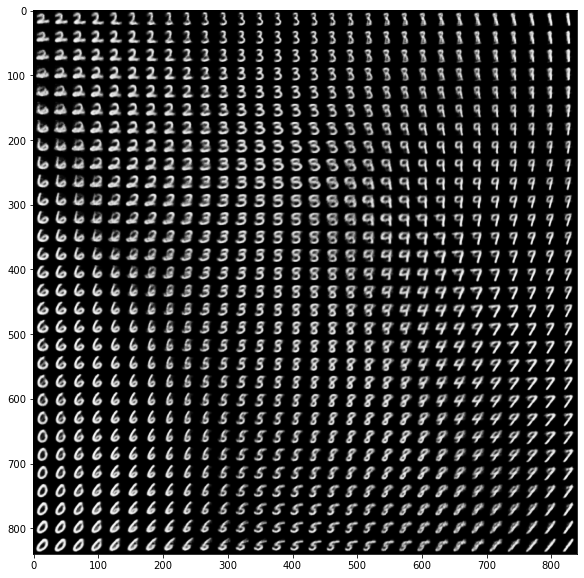

In [9]:
from scipy.stats import norm

batch_size = 150
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[0].reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="Greys_r")
plt.show()

---

### VAE를 이용한 실험

In [6]:
vae = kr.Model(input_layer, y)
vae.compile(optimizer='adam', loss=None)
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [8]:
from scipy.stats import norm

def make_Mnist_task(train_set = [0,1,2,3,4,5,6,7,8,9], test_set = [0,1,2,3,4,5,6,7,8,9]):
    
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    print("Mnist Data original train_set",x_train.shape, "\nMnist Data original test_set ", x_test.shape, "\n")

    x_train = x_train.astype('float32') / 255.
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.astype('float32') / 255.
    x_test = x_test.reshape(x_test.shape + (1,))
    
    print("train_set ->", train_set, "\ntest_set  ->", test_set, "\n")
    
    task_train_data = [idx for idx, val in enumerate(y_train) if val in train_set]
    task_test_data = [idx for idx, val in enumerate(y_test) if val in test_set]
    
    print("Mnist Data task train_set",x_train[task_train_data].shape, "\nMnist Data task test_set ", x_test[task_test_data].shape, "\n")
    
    return x_train[task_train_data], x_test[task_test_data]

def disp_vae(batch_size = 1, n = 30, digit_size = 28, min_v = 0.05, max_v = 0.95):
    
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = norm.ppf(np.linspace(min_v, max_v, n))
    grid_y = norm.ppf(np.linspace(min_v, max_v, n))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
            x_decoded = decoder.predict(z_sample, batch_size=batch_size)

            digit = x_decoded[0].reshape(digit_size, digit_size)

            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

def gen_from_vae(batch_size = 1, n = 75, digit_size = 28, min_v = 0.05, max_v = 0.95):
    
    maked_samples = np.empty((1, digit_size, digit_size, 1))
    grid_x = norm.ppf(np.linspace(min_v, max_v, n))
    grid_y = norm.ppf(np.linspace(min_v, max_v, n))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
            x_decoded = decoder.predict(z_sample, batch_size=batch_size)

            digit = np.expand_dims(x_decoded[0], axis = 0)
            maked_samples = np.append(maked_samples, digit, axis = 0)

    maked_samples = np.delete(maked_samples, [0, 0], axis=0)
    print("sample_size =", maked_samples.shape)
    return maked_samples

def data_set_merge(data_1, data_2, suffle = True):
    temp_data = np.append(data_1, data_2, axis = 0)
    print("--------------------------------------------------")
    print("data_1 shape ->", data_1.shape, "\ndata_2 shape ->", data_2.shape)
    
    if suffle:
        idx = np.arange(temp_data.shape[0])
        np.random.shuffle(idx)
        temp_data = temp_data[idx]
    print("\nmerged data shape ->", temp_data.shape)
    return temp_data

In [9]:
Task1_train, Task1_test = make_Mnist_task([0, 1], [0, 1])

Mnist Data original train_set (60000, 28, 28) 
Mnist Data original test_set  (10000, 28, 28) 

train_set -> [0, 1] 
test_set  -> [0, 1] 

Mnist Data task train_set (12665, 28, 28, 1) 
Mnist Data task test_set  (2115, 28, 28, 1) 



In [10]:
%%time
vae.fit(x=Task1_train, y=None, shuffle=True, epochs=30,
        batch_size=100, validation_data=(Task1_test, None), verbose=1)

Train on 12665 samples, validate on 2115 samples
Epoch 1/30
12665/12665 [==============================] - 3s 209us/sample - loss: 0.2945 - val_loss: 0.2015
Epoch 2/30
12665/12665 [==============================] - 1s 52us/sample - loss: 0.1892 - val_loss: 0.1749
Epoch 3/30
12665/12665 [==============================] - 1s 55us/sample - loss: 0.1694 - val_loss: 0.1611
Epoch 4/30
12665/12665 [==============================] - 1s 55us/sample - loss: 0.1562 - val_loss: 0.1552
Epoch 5/30
12665/12665 [==============================] - 1s 71us/sample - loss: 0.1433 - val_loss: 0.1381
Epoch 6/30
12665/12665 [==============================] - 1s 66us/sample - loss: 0.1375 - val_loss: 0.1340
Epoch 7/30
12665/12665 [==============================] - 1s 55us/sample - loss: 0.1341 - val_loss: 0.1275
Epoch 8/30
12665/12665 [==============================] - 1s 63us/sample - loss: 0.1261 - val_loss: 0.1235
Epoch 9/30
12665/12665 [==============================] - 1s 77us/sample - loss: 0.1241 - val_

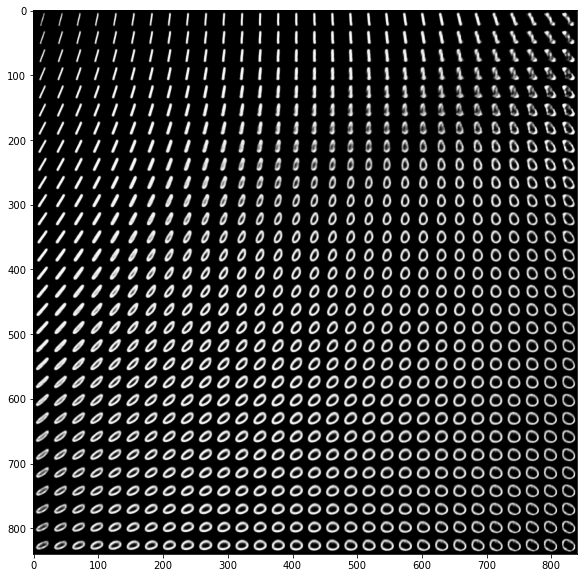

In [11]:
disp_vae()

In [12]:
maked_Task1_samples = gen_from_vae(n = 112)

sample_size = (12544, 28, 28, 1)


In [13]:
Task2_train, Task2_test = make_Mnist_task([2, 3], [0, 1, 2, 3])

Task2_train = data_set_merge(Task2_train, maked_Task1_samples)

Mnist Data original train_set (60000, 28, 28) 
Mnist Data original test_set  (10000, 28, 28) 

train_set -> [2, 3] 
test_set  -> [0, 1, 2, 3] 

Mnist Data task train_set (12089, 28, 28, 1) 
Mnist Data task test_set  (4157, 28, 28, 1) 

--------------------------------------------------
data_1 shape -> (12089, 28, 28, 1) 
data_2 shape -> (12544, 28, 28, 1)

merged data shape -> (24633, 28, 28, 1)


In [14]:
%%time
vae.fit(x=Task2_train, y=None, shuffle=True, epochs=30,
        batch_size=100, validation_data=(Task2_test, None), verbose=1)

Train on 24633 samples, validate on 4157 samples
Epoch 1/30
24633/24633 [==============================] - 2s 95us/sample - loss: 0.2053 - val_loss: 0.1801
Epoch 2/30
24633/24633 [==============================] - 2s 97us/sample - loss: 0.1977 - val_loss: 0.1782
Epoch 3/30
24633/24633 [==============================] - 2s 76us/sample - loss: 0.1928 - val_loss: 0.1787
Epoch 4/30
24633/24633 [==============================] - 2s 100us/sample - loss: 0.1894 - val_loss: 0.1797
Epoch 5/30
24633/24633 [==============================] - 2s 96us/sample - loss: 0.1875 - val_loss: 0.1814
Epoch 6/30
24633/24633 [==============================] - 2s 76us/sample - loss: 0.1861 - val_loss: 0.1862
Epoch 7/30
24633/24633 [==============================] - 2s 76us/sample - loss: 0.1852 - val_loss: 0.1834
Epoch 8/30
24633/24633 [==============================] - 2s 76us/sample - loss: 0.1844 - val_loss: 0.1869
Epoch 9/30
24633/24633 [==============================] - 2s 64us/sample - loss: 0.1836 - val_

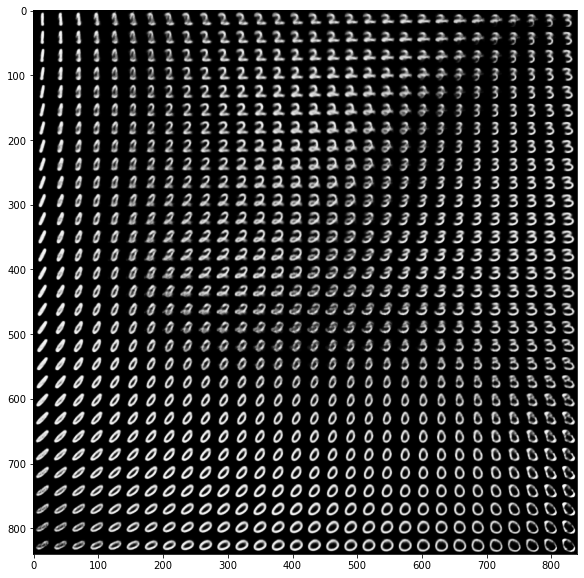

In [15]:
disp_vae()

In [16]:
maked_Task2_samples = gen_from_vae(n = 157)

sample_size = (24649, 28, 28, 1)


In [17]:
Task3_train, Task3_test = make_Mnist_task([4, 5], [0, 1, 2, 3, 4, 5])

Task3_train = data_set_merge(Task3_train, maked_Task2_samples)

Mnist Data original train_set (60000, 28, 28) 
Mnist Data original test_set  (10000, 28, 28) 

train_set -> [4, 5] 
test_set  -> [0, 1, 2, 3, 4, 5] 

Mnist Data task train_set (11263, 28, 28, 1) 
Mnist Data task test_set  (6031, 28, 28, 1) 

--------------------------------------------------
data_1 shape -> (11263, 28, 28, 1) 
data_2 shape -> (24649, 28, 28, 1)

merged data shape -> (35912, 28, 28, 1)


In [18]:
%%time
vae.fit(x=Task3_train, y=None, shuffle=True, epochs=30,
        batch_size=100, validation_data=(Task3_test, None), verbose=1)

Train on 35912 samples, validate on 6031 samples
Epoch 1/30
35912/35912 [==============================] - 3s 84us/sample - loss: 0.1972 - val_loss: 0.2461
Epoch 2/30
35912/35912 [==============================] - 3s 82us/sample - loss: 0.1926 - val_loss: 0.2557
Epoch 3/30
35912/35912 [==============================] - 3s 95us/sample - loss: 0.1915 - val_loss: 0.2567
Epoch 4/30
35912/35912 [==============================] - 4s 114us/sample - loss: 0.1909 - val_loss: 0.2554
Epoch 5/30
35912/35912 [==============================] - 3s 82us/sample - loss: 0.1903 - val_loss: 0.2528
Epoch 6/30
35912/35912 [==============================] - 3s 70us/sample - loss: 0.1899 - val_loss: 0.2587
Epoch 7/30
35912/35912 [==============================] - 4s 111us/sample - loss: 0.1896 - val_loss: 0.2574
Epoch 8/30
35912/35912 [==============================] - 3s 73us/sample - loss: 0.1893 - val_loss: 0.2599
Epoch 9/30
35912/35912 [==============================] - 3s 82us/sample - loss: 0.1890 - val

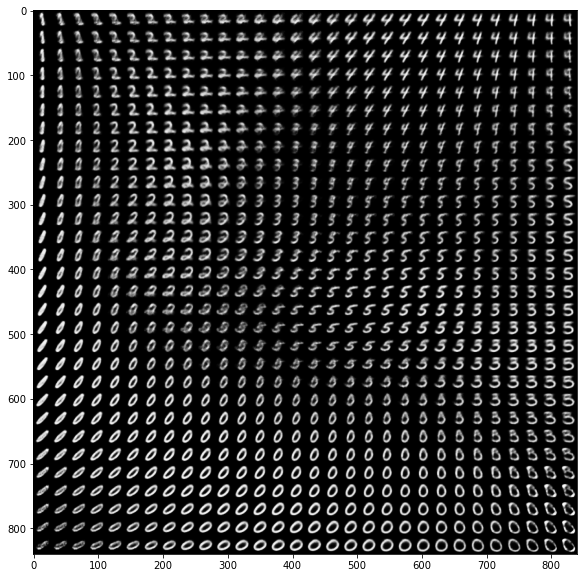

In [19]:
disp_vae()

In [20]:
maked_Task3_samples = gen_from_vae(n = 195)

Task4_train, Task4_test = make_Mnist_task([6, 7], [0, 1, 2, 3, 4, 5, 6, 7])

Task4_train = data_set_merge(Task4_train, maked_Task3_samples)

vae.fit(x=Task4_train, y=None, shuffle=True, epochs=30,
        batch_size=100, validation_data=(Task4_test, None), verbose=1)

sample_size = (38025, 28, 28, 1)
Mnist Data original train_set (60000, 28, 28) 
Mnist Data original test_set  (10000, 28, 28) 

train_set -> [6, 7] 
test_set  -> [0, 1, 2, 3, 4, 5, 6, 7] 

Mnist Data task train_set (12183, 28, 28, 1) 
Mnist Data task test_set  (8017, 28, 28, 1) 

--------------------------------------------------
data_1 shape -> (12183, 28, 28, 1) 
data_2 shape -> (38025, 28, 28, 1)

merged data shape -> (50208, 28, 28, 1)
Train on 50208 samples, validate on 8017 samples
Epoch 1/30
50208/50208 [==============================] - 4s 78us/sample - loss: 0.1809 - val_loss: 0.2841
Epoch 2/30
50208/50208 [==============================] - 3s 63us/sample - loss: 0.1761 - val_loss: 0.2946
Epoch 3/30
50208/50208 [==============================] - 4s 74us/sample - loss: 0.1751 - val_loss: 0.2927
Epoch 4/30
50208/50208 [==============================] - 4s 83us/sample - loss: 0.1745 - val_loss: 0.2944
Epoch 5/30
50208/50208 [==============================] - 5s 90us/sample - loss

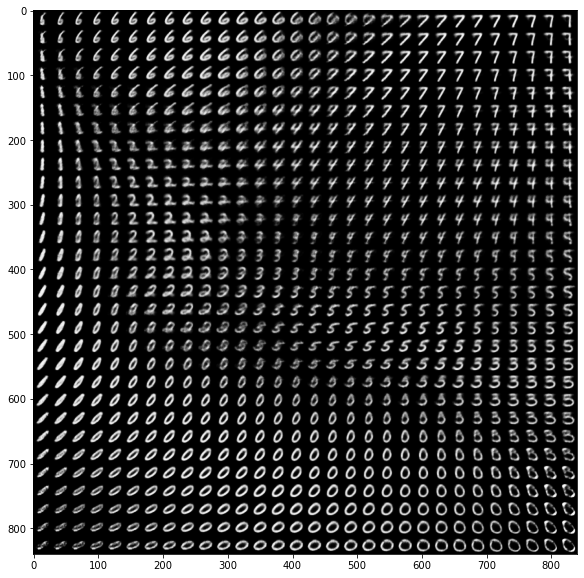

In [21]:
disp_vae()

In [22]:
maked_Task4_samples = gen_from_vae(n = 219)

Task5_train, Task5_test = make_Mnist_task([8, 9], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Task5_train = data_set_merge(Task5_train, maked_Task3_samples)

vae.fit(x=Task5_train, y=None, shuffle=True, epochs=30,
        batch_size=100, validation_data=(Task5_test, None), verbose=1)

sample_size = (47961, 28, 28, 1)
Mnist Data original train_set (60000, 28, 28) 
Mnist Data original test_set  (10000, 28, 28) 

train_set -> [8, 9] 
test_set  -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 

Mnist Data task train_set (11800, 28, 28, 1) 
Mnist Data task test_set  (10000, 28, 28, 1) 

--------------------------------------------------
data_1 shape -> (11800, 28, 28, 1) 
data_2 shape -> (38025, 28, 28, 1)

merged data shape -> (49825, 28, 28, 1)
Train on 49825 samples, validate on 10000 samples
Epoch 1/30
49825/49825 [==============================] - 3s 66us/sample - loss: 0.1813 - val_loss: 0.2427
Epoch 2/30
49825/49825 [==============================] - 3s 68us/sample - loss: 0.1786 - val_loss: 0.2486
Epoch 3/30
49825/49825 [==============================] - 5s 96us/sample - loss: 0.1781 - val_loss: 0.2456
Epoch 4/30
49825/49825 [==============================] - 4s 90us/sample - loss: 0.1778 - val_loss: 0.2432
Epoch 5/30
49825/49825 [==============================] - 4s 83us/sampl

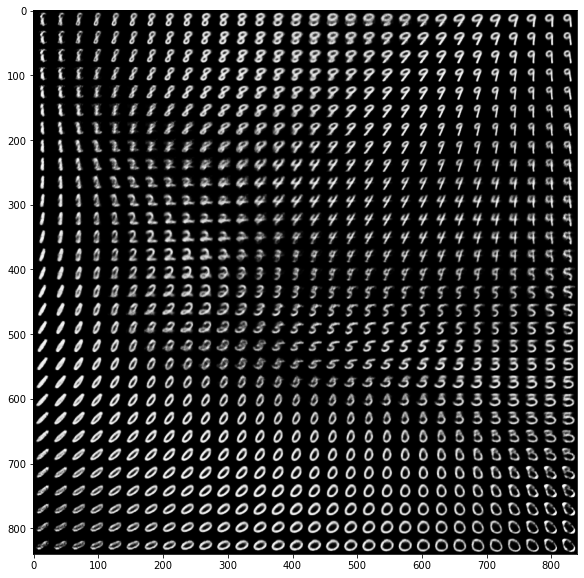

In [23]:
disp_vae()

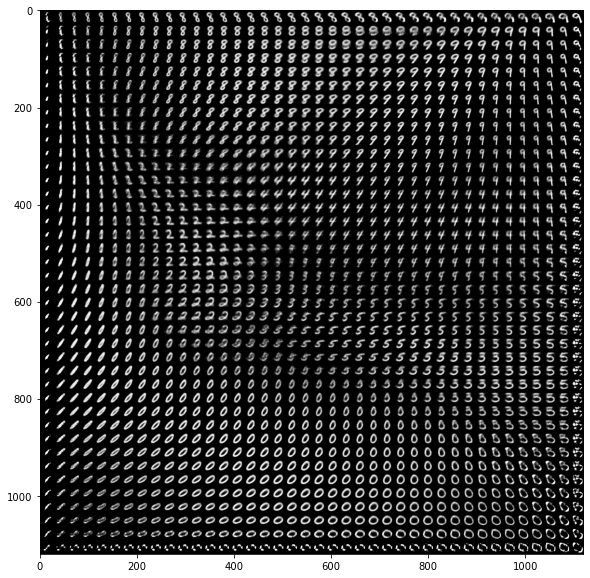

In [44]:
disp_vae(n = 40, min_v = 0.00005, max_v = 0.99995)